# Twitter Sentimental Analysis

In [1]:
# Importing the dependecies

import tweepy                             # API for getting twitter info
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os                                 # To get the api keys stored as environment variables
from textblob import TextBlob             # To analyse the sentiment
from wordcloud import WordCloud,STOPWORDS # To make a wordcloud
from dotenv import load_dotenv            # For loading the environment variables
import datetime
import time

In [2]:
load_dotenv()

True

In [3]:
# Storing the API KEYS provided by Twitter Dev Account

api_key             = os.getenv('api_key')
api_secret_key      = os.getenv('api_secret_key')
access_token        = os.getenv('access_token')
access_token_secret = os.getenv('access_token_secret')

In [4]:
# Authorizing the API

auth = tweepy.OAuthHandler(api_key,api_secret_key)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)

In [5]:
def cleaned_tweet(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "",txt).split())

In [6]:
def calculate_polarity(tweet):
    blob = TextBlob(tweet)
    return blob.sentiment.polarity

In [7]:
tweets = []
created_at = []

def get_tweets(searchword,formatted_date,num_of_tweets):
    for tweet in tweepy.Cursor(api.search_tweets,q=searchword,tweet_mode='extended',lang='en',result_type='recent',until=formatted_date).items(num_of_tweets):
        tweets.append(tweet.full_text)
        created_at.append(tweet.created_at)

In [40]:
def get_user_inputs():
    
    global tweets
    global created_at
    tweets = []
    created_at = []

    hashtag = input("Search a keyword :")
    searchword = hashtag+'-filter:retweets AND -filter:replies'
    
    num_of_tweets = int(input("Enter number of tweets that must be scraped per day :"))    
    
    today = datetime.date.today()
    until = int(input("Enter number of days until the tweets must be scraped :"))
    
    for i in range(until,0,-1):
        delta = datetime.timedelta(days = until-2)
        until_date = today - delta
        formatted_date = until_date.strftime("%Y-%m-%d")
        until = until - 1
        get_tweets(searchword,formatted_date,num_of_tweets)
    
get_user_inputs()

Search a keyword :INDvsPAK
Enter number of tweets that must be scraped per day :100
Enter number of days until the tweets must be scraped :10


In [41]:
data = {"Tweet":tweets,
        "Date":created_at}
dummy = pd.DataFrame(data)

df = dummy.copy()
df['Tweet'] = df['Tweet'].apply(lambda x:cleaned_tweet(x))
df['Polarity'] = df['Tweet'].apply(lambda x:calculate_polarity(x))
df.drop_duplicates(inplace=True)

In [42]:
df.loc[df['Polarity'] > 0, "Sentiment"] = "Positive"
df.loc[df['Polarity'] == 0, "Sentiment"] = "Neutral"
df.loc[df['Polarity'] < 0, "Sentiment"] = "Negative"

In [43]:
df

,Tweet,Date,Polarity,Sentiment
0,Tickets available for India vs Pakistan Ticket...,2021-10-21 23:15:24+00:00,-0.050000,Negative
1,Who should be the part of Pakistans playing 11...,2021-10-21 23:14:32+00:00,0.000000,Neutral
2,All set ready to fly to Dubai Ready for IndVsP...,2021-10-21 22:33:35+00:00,0.400000,Positive
3,I am in form Azam says ahead of India T20World...,2021-10-21 22:03:51+00:00,0.000000,Neutral
4,Turkeys MIT brings down 15member Mossad spy ne...,2021-10-21 21:36:29+00:00,-0.155556,Negative
...,...,...,...,...
947,Congratulations Pakistan theyre playing some b...,2021-10-30 02:01:07+00:00,0.322727,Positive
948,We will come back stronger IndvsPak TeamIndia ...,2021-10-30 01:57:15+00:00,0.000000,Neutral
949,Firstly I used to think majority Indian Journa...,2021-10-30 01:30:53+00:00,-0.412500,Negative
950,This is a real shame everybody has the right t...,2021-10-30 00:18:19+00:00,0.161905,Positive


In [44]:
pos = df[df['Sentiment']=='Positive']
neg = df[df['Sentiment']=='Negative']

### Pie chart for Positive and Negative Tweets

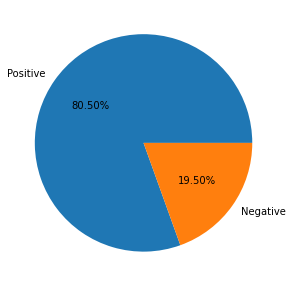

In [51]:
plt.figure(figsize=[10,5])
labels = ['Positive','Negative']
values = [pos.shape[0],neg.shape[0]]
plt.pie(values, labels=labels, autopct='%1.2f%%')
plt.show()

In [46]:
df_day = df.groupby([pd.Grouper(key='Date', freq='D'), 'Sentiment']).size().unstack('Sentiment')
df_day.index = df_day.index.strftime('%Y-%m-%d')
df_day.drop(columns='Neutral',inplace=True)
df_day

Sentiment,Negative,Positive
Date,,
2021-10-21,11,40
2021-10-22,6,52
2021-10-23,5,53
2021-10-24,9,53
2021-10-25,15,48
2021-10-26,17,49
2021-10-27,24,54
2021-10-28,14,59
2021-10-29,8,55


### Positive and Negative Tweets over the Days

<Figure size 432x288 with 0 Axes>

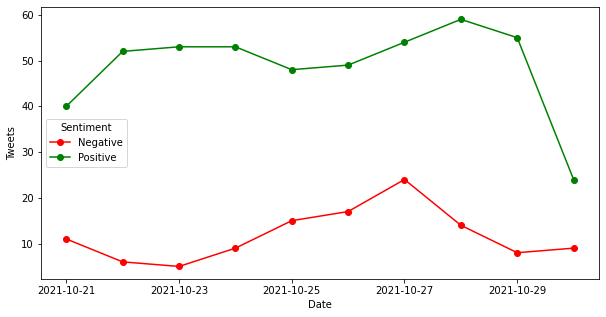

In [47]:
plt.figure()
df_day.plot(marker='o',color=['red','green'],legend=True,label=['Positive','Negative'],figsize=(10,5))
plt.ylabel('Tweets')
plt.show()

In [48]:
twitter_mask = plt.imread("./twitter_mask.jpg")

### WordCloud

WordCloud for Posititve Tweets


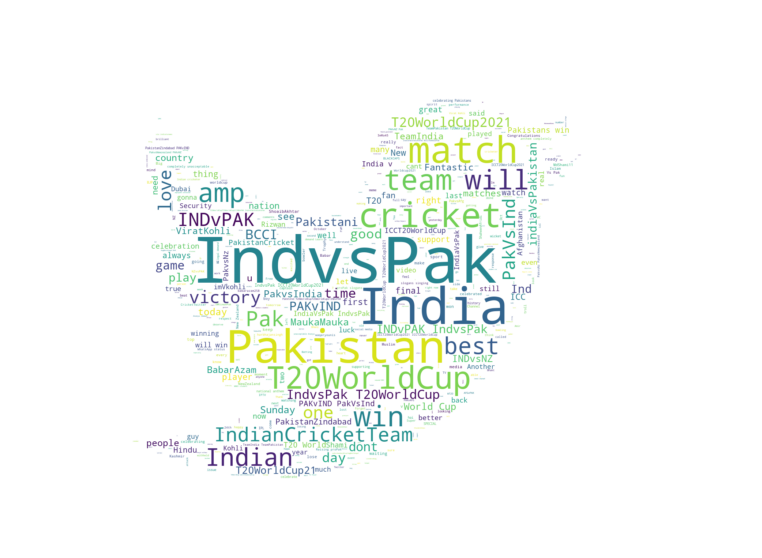

In [49]:
print("WordCloud for Posititve Tweets")
text = " ".join(tweet for tweet in pos['Tweet'])
wc = WordCloud(background_color="white", max_words=500, mask=twitter_mask, stopwords=STOPWORDS)
wc.generate(text)
plt.figure(figsize=[20,10])
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

WordCloud for Negative Tweets


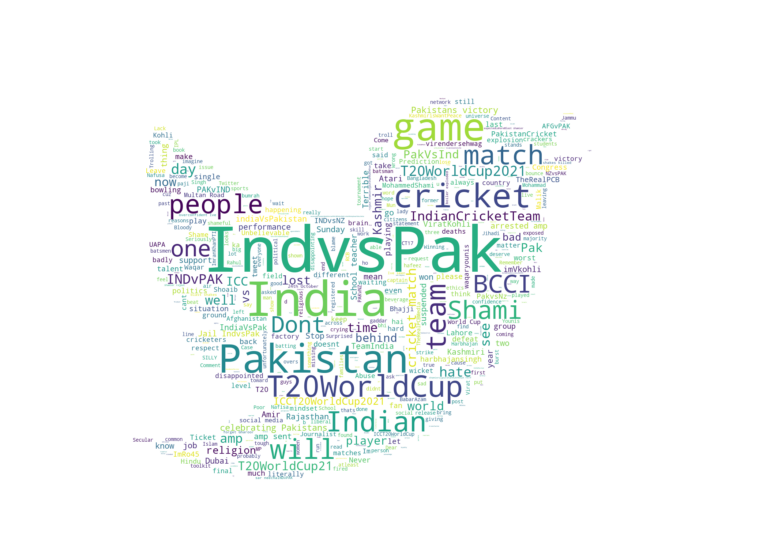

In [50]:
print("WordCloud for Negative Tweets")
text = " ".join(tweet for tweet in neg['Tweet'])
wc = WordCloud(background_color="white", max_words=500, mask=twitter_mask, stopwords=STOPWORDS)
wc.generate(text)
plt.figure(figsize=[20,10])
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()